# Return Prediction from Time Series

## Setup

### Imports

In [4]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pyro
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from src.utils.returns import create_lagged_return_sequences
from src.modules.bayesian.lstm import BayesianLSTM
import matplotlib.pyplot as plt

### Constants

In [2]:
symbol = "TSLA"
lag = 5
predict_days = 5

## Dataset

### Loading

In [3]:
df = pd.read_csv(f'data/data_{symbol}.csv')

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df = df['2024-04-01':]

df = df[['return']]

### Feature and Target Preparation

In [6]:
scaler = StandardScaler()
returns = scaler.fit_transform(df.values)

In [7]:
X_lagged, y = create_lagged_return_sequences(returns, lag)
X_train, y_train = X_lagged[:-predict_days], y[:-predict_days]
X_test, y_test = X_lagged[-predict_days:], y[-predict_days:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).squeeze()
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).squeeze()

## Model Training

### Pipeline

In [35]:
pyro.set_rng_seed(42)
pyro.clear_param_store()

model = BayesianLSTM("model2", input_size=1, hidden_size=16, output_size=1)

optimizer = Adam({"lr": 1e-3})
guide = AutoDiagonalNormal(model)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

loss_log = []

for step in range(5000):
    loss = svi.step(X_train, y_train)
    loss_log.append(loss)
    if step % 100 == 0:
        print(f"[Step {step}] Loss: {loss:.4f}")


[Step 0] Loss: 2565.8814
[Step 100] Loss: 2417.6075
[Step 200] Loss: 2208.8324
[Step 300] Loss: 2170.2510
[Step 400] Loss: 2029.5173
[Step 500] Loss: 1919.0526
[Step 600] Loss: 1841.9188
[Step 700] Loss: 1724.2978
[Step 800] Loss: 1658.6047
[Step 900] Loss: 1568.5271
[Step 1000] Loss: 1478.6507
[Step 1100] Loss: 1357.4829
[Step 1200] Loss: 1312.8253
[Step 1300] Loss: 1233.9579
[Step 1400] Loss: 1118.8716
[Step 1500] Loss: 1086.7206
[Step 1600] Loss: 963.5374
[Step 1700] Loss: 913.2425
[Step 1800] Loss: 859.1135
[Step 1900] Loss: 789.2166
[Step 2000] Loss: 749.8971
[Step 2100] Loss: 726.0508
[Step 2200] Loss: 633.1114
[Step 2300] Loss: 627.3856
[Step 2400] Loss: 570.0233
[Step 2500] Loss: 569.9040
[Step 2600] Loss: 529.6453
[Step 2700] Loss: 486.3190
[Step 2800] Loss: 447.4138
[Step 2900] Loss: 463.9183
[Step 3000] Loss: 470.2263
[Step 3100] Loss: 440.3681
[Step 3200] Loss: 426.6437
[Step 3300] Loss: 411.7084
[Step 3400] Loss: 424.3031
[Step 3500] Loss: 410.5253
[Step 3600] Loss: 406.90

### Loss Visualization

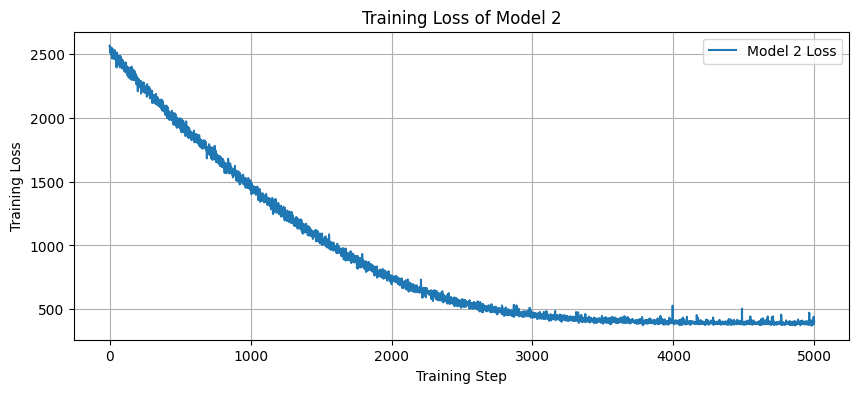

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(loss_log, label='Model 2 Loss')
plt.title("Training Loss of Model 2")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

## Model Testing

### Pipeline

In [37]:
model.eval()
predictive = Predictive(model, guide=guide, num_samples=100)
samples = predictive(X_test)

posterior_preds = samples["model2_obs"]

mean = samples["model2_obs"].mean(0).detach().numpy()
std = samples["model2_obs"].std(0).detach().numpy()

mean_rescaled = scaler.inverse_transform(mean.reshape(-1, 1)).flatten()
std_rescaled = std * scaler.scale_[0]

### Prediction Visualization

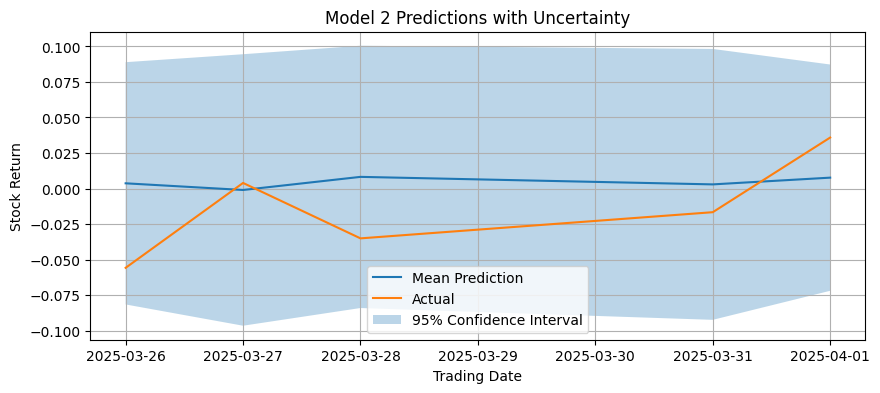

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(df[-predict_days:].index, mean_rescaled, label='Mean Prediction')
plt.plot(df[-predict_days:].index, df[-predict_days:], label='Actual')
plt.fill_between(
    df['return'][-predict_days:].index,
    mean_rescaled - 2 * std_rescaled,
    mean_rescaled + 2 * std_rescaled,
    alpha=0.3, label='95% Confidence Interval'
)
plt.title('Model 2 Predictions with Uncertainty')
plt.ylabel("Stock Return")
plt.xlabel("Trading Date")
plt.grid(True)
plt.legend()
plt.show()